### Import Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/apple/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df1 = pd.read_csv('data/Final_Label_10000.csv')
df1 = df1[df1['Tagger ID'] == 'jy']
print(df1.shape)
df1.head()

df2 = pd.read_csv('data/jincheng3000.csv')
print(df2.shape)

df =pd.concat([df1, df2], ignore_index=True)

df = df.drop(['commit link_x', 'excluded','Commit ID','total_files','deleted_files','check', 'Tagger ID','commit link','testing', 'build'], axis = 1)
df = df[['application', 'csha', 'commit message', 'maintenance', 'Bug fix', 
        'Documentation', 'Clean up','Source Control', 'Feature Add', 'Merge', 'Refactoring','Token Replace']]
print(df.shape)
df.head()

(2952, 22)
(2952, 22)
(5904, 12)


,application,csha,commit message,maintenance,Bug fix,Documentation,Clean up,Source Control,Feature Add,Merge,Refactoring,Token Replace
0,google-closure-compiler,d84964855e190bf663d38b7fa37f3746deb2b3aa,chang look extend interfac first,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,google-closure-compiler,d1a63725ce21a1c6901ec762dd745ac58b8866b2,support,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,google-closure-compiler,47f75968703051dc09ed001ee84cce81e78835f7,mark,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,google-closure-compiler,ee5c095b4237da991a911fa459514ca942ede7e0,remov thread warn report use think anyon under...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,google-closure-compiler,fc1f4e841b3ef0f6fa4578b673e803c3df733a0d,make class statement call work correct fix,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tags Preprocessing

In [3]:
new_df = df.copy()
def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Source Control'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

Corrective : 627
Adaptive : 742
Perfective : 3338
Implementation : 864
Non_functional : 95
Other : 95


Corrective : 627
Adaptive : 742
Perfective : 3338
Implementation : 864
1    5020
0     613
2     262
3       9
dtype: int64


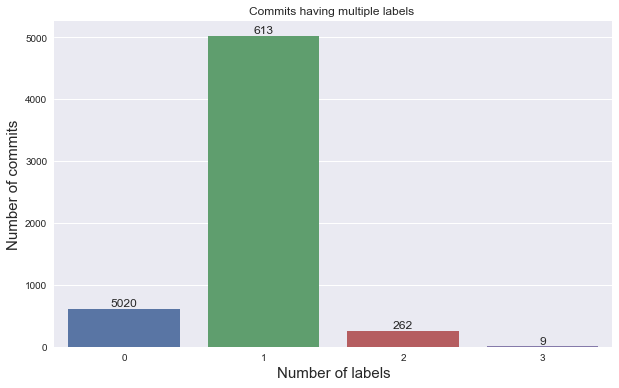

current number of samples: 5904
number of samples after drop:5020


In [4]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

# Drop target col
# new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
# target_col = ['Adaptive','Perfective','Implementation']

# new_df = new_df[new_df['Implementation']!=1].reset_index(drop=True)
# target_col = ['Adaptive','Perfective','Corrective']

# form target cols
new_df['target_class'] = np.argmax(new_df[target_col].values, axis = 1)
new_df = new_df[~new_df['commit message'].isnull()]

### TD-IDF and Machine Learning

In [5]:
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from scipy.sparse import coo_matrix, hstack

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))

In [6]:
# # drop too long commits
# new_df['len_seq'] = new_df.apply(lambda row: len(row['commit message'].split()), axis = 1)
# new_df = new_df[new_df['len_seq'] >= 3].reset_index(drop = True)

In [7]:
def tfidf_features(X):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=0, max_df=1.0, ngram_range=(1, 2),token_pattern='(\S+)')
    
    X = tfidf_vectorizer.fit_transform(X)
    
    return X,tfidf_vectorizer.vocabulary_

X = new_df['commit message'].values
y = new_df['target_class'].values
X_tfidf, tfidf_vocab = tfidf_features(X)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

print('X train shape : ', X_train.shape)
print('X test shape : ', X_test.shape)

X train shape :  (4410, 28729)
X test shape :  (490, 28729)


### Logistic Regression

In [8]:
from sklearn.model_selection import StratifiedKFold, KFold

In [9]:
skf = KFold(n_splits=10, random_state = 42, shuffle = True)
skf.get_n_splits(X_tfidf, y)

eval_result = []
for train_index, test_index in skf.split(X, y):
    print('========================================================')
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    clf = LogisticRegression(penalty = 'l1', C = 2.5, random_state=0, solver='saga', multi_class='multinomial',max_iter=1000).fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    predictions = clf.predict_proba(X_test) 
    print_evaluation_scores(y_test, y_pre_test)
    
    accu = accuracy_score(y_test, y_pre_test)
    f1 = f1_score(y_test, y_pre_test, average='macro')
    eval_result.append((accu, f1))

Accuracy: 0.7040816326530612
F1-score macro: 0.4831495990571587
F1-score micro: 0.7040816326530612
F1-score weighted: 0.6607443676131267
Accuracy: 0.6428571428571429
F1-score macro: 0.44427745131939383
F1-score micro: 0.6428571428571429
F1-score weighted: 0.5856656128086379


/Users/apple/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy: 0.6551020408163265
F1-score macro: 0.43879185809547927
F1-score micro: 0.6551020408163265
F1-score weighted: 0.6054860747612724
Accuracy: 0.6571428571428571
F1-score macro: 0.4596570416751431
F1-score micro: 0.6571428571428571
F1-score weighted: 0.6149135114336268


KeyboardInterrupt: 

In [44]:
sum_acc = 0
sum_f1 = 0
for item in eval_result:
    sum_acc += item[0]
    sum_f1 += item[1]

print(sum_acc/10)
print(sum_f1/10)

0.6701996717767039
0.4656351148498093


#### Logsitic Regression One VS Rest Classifier

In [17]:
from sklearn.model_selection import cross_val_score, GridSearchCV

#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'penalty': ['l1'], 
                'C': [1.5,2.5,3.5,4.5,5.5,6.5,8,10,15], 
                'multi_class':['multinomial','ovr']}]

clf = LogisticRegression(random_state=0,solver='saga',n_jobs=-1,max_iter=1000)

lr_model = GridSearchCV(clf, params_grid, cv=5)
lr_model.fit(X_train, y_train)

# View the accuracy score
print('Best score for training data:', lr_model.best_score_,"\n") 
print('Best parameters for training data:',lr_model.best_params_,'\n')

# View the best parameters for the model found using grid search
print('Best C:',lr_model.best_estimator_.C,"\n") 
print('Best penalty:',lr_model.best_estimator_.penalty,"\n")

final_model = lr_model.best_estimator_
Y_pred = lr_model.predict(X_test)
print_evaluation_scores(y_test, Y_pred)

/Users/apple/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/apple/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/apple/venv/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best score for training data: 0.6707482993197279 

Best parameters for training data: {'C': 5.5, 'multi_class': 'ovr', 'penalty': 'l1'} 

Best C: 5.5 

Best penalty: l1 

Accuracy: 0.7081632653061225
F1-score macro: 0.5220289715581529
F1-score micro: 0.7081632653061225
F1-score weighted: 0.6755286254821168


### SVM

In [18]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000], 'decision_function_shape':['ovo','ovr']},
               {'kernel': ['linear'], 'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000], 'decision_function_shape':['ovo','ovr']}]

svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'gamma': [0.1, 0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']},
                         {'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
            

In [19]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best parameters for training data:',svm_model.best_params_,'\n')

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)
print_evaluation_scores(y_test, Y_pred)

Best score for training data: 0.6798185941043083 

Best parameters for training data: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'} 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.1 

Accuracy: 0.7122448979591837
F1-score macro: 0.5106395429119893
F1-score micro: 0.7122448979591838
F1-score weighted: 0.6714444755973846


### Dense Layer Neural Network

In [20]:
import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.layers.merge import Concatenate
from keras import regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow import set_random_seed
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import warnings
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [21]:
def tfidf_features(X):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=0, max_df=1.0, ngram_range=(1, 2))
    
    X = tfidf_vectorizer.fit_transform(X)
    
    return X,tfidf_vectorizer.vocabulary_

def dense_layer(n_input, 
                hidden_layers = [512], 
                dropout_rate = 0, 
                l2_penalty = 0.1, 
                optimizer = 'adam',
                lr = 0.001,
                n_class = 4): 
    
    model = Sequential()
    
    # hidden layers
    for index, hidden_units in enumerate(hidden_layers):       
        if index == 0:
            # specify the input_dim to be the number of features for the first layer
            model.add(Dense(hidden_units, input_dim = n_input, kernel_regularizer = l2(l2_penalty)))
        else:
            model.add(Dense(hidden_units, kernel_regularizer = l2(l2_penalty)))
        
        # insert BatchNorm layer immediately after fully connected layers
        # and before activation layer
        model.add(BatchNormalization())
        model.add(PReLU())        
        if dropout_rate != 0:
            model.add(Dropout(dropout_rate))
    
    # finial layers
    model.add(Dense(n_class, activation="softmax"))
    model.compile(loss="categorical_crossentropy", 
                    optimizer= optimizers.Adam(lr=lr),
                    metrics=['accuracy'])
    return model 

dense_layer(474).summary()
X = new_df['commit message'].values
y = new_df[target_col].values
X_tfidf, tfidf_vocab = tfidf_features(X)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

print('X train shape : ', X_train.shape)
print('X test shape : ', X_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

print('X train shape : ', X_train.shape)
print('X val shape : ', X_val.shape)

W0819 09:45:31.154328 4335547840 deprecation_wrapper.py:119] From /Users/apple/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 09:45:31.158000 4335547840 deprecation_wrapper.py:119] From /Users/apple/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 09:45:31.181859 4335547840 deprecation_wrapper.py:119] From /Users/apple/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 09:45:31.378143 4335547840 deprecation_wrapper.py:119] From /Users/apple/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0819 09:45:31

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               243200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 512)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 247,812
Trainable params: 246,788
Non-trainable params: 1,024
_________________________________________________________________
X train shape :  (4410, 28537)
X test shape :  (490, 28537)
X train shape :  (3969, 28537)
X val shape :  (441, 28537)


In [24]:
dense_network = dense_layer(X_train.shape[1],n_class = 4,
                            hidden_layers = [512], 
                            dropout_rate = 0.5, 
                            l2_penalty = 0.3)
early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.01, patience = 10, verbose = 0, restore_best_weights = True)

history = dense_network.fit(X_train, y_train, batch_size=256, epochs=200,
                            validation_data=(X_val, y_val), verbose=2, shuffle = False, callbacks = [early_stop])

y_pred = np.argmax(dense_network.predict(X_test), axis = 1)
y_test_new = np.argmax(y_test, axis = 1)
print_evaluation_scores(y_test_new, y_pred)

Train on 3969 samples, validate on 441 samples
Epoch 1/200
 - 15s - loss: 95.5121 - acc: 0.5649 - val_loss: 11.6083 - val_acc: 0.6576
Epoch 2/200
 - 12s - loss: 12.4152 - acc: 0.6893 - val_loss: 5.7216 - val_acc: 0.6599
Epoch 3/200
 - 9s - loss: 3.1621 - acc: 0.6805 - val_loss: 2.4880 - val_acc: 0.6485
Epoch 4/200
 - 9s - loss: 1.9462 - acc: 0.6697 - val_loss: 1.7070 - val_acc: 0.6576
Epoch 5/200
 - 9s - loss: 1.6472 - acc: 0.6684 - val_loss: 1.6937 - val_acc: 0.6712
Epoch 6/200
 - 11s - loss: 1.6593 - acc: 0.6780 - val_loss: 1.7389 - val_acc: 0.6712
Epoch 7/200
 - 10s - loss: 1.7105 - acc: 0.6805 - val_loss: 1.7967 - val_acc: 0.6735
Epoch 8/200
 - 9s - loss: 1.7535 - acc: 0.6848 - val_loss: 1.8410 - val_acc: 0.6803
Epoch 9/200
 - 9s - loss: 1.7944 - acc: 0.6878 - val_loss: 1.8891 - val_acc: 0.6871
Epoch 10/200
 - 9s - loss: 1.8300 - acc: 0.6863 - val_loss: 1.9307 - val_acc: 0.6757
Epoch 11/200
 - 12s - loss: 1.8663 - acc: 0.6896 - val_loss: 1.9637 - val_acc: 0.6984
Epoch 12/200
 - 13s

In [ ]:
eval_